# Modelagem Preditiva - Avaliação IMDb

Este notebook implementa a estratégia de modelagem definida na análise exploratória para prever as notas do IMDb. Seguiremos as etapas:

1. **Preparação dos Dados**
   - Carregamento e pré-processamento
   - Feature engineering
   - Divisão treino/teste

2. **Baseline Model**
   - Regressão Linear
   - Avaliação inicial

3. **Modelo Intermediário**
   - Random Forest e XGBoost
   - Otimização de hiperparâmetros

4. **Modelo Avançado**
   - Features de NLP
   - Ensemble/Stacking

5. **Avaliação Final**
   - Comparação de modelos
   - SHAP Analysis
   - Seleção do melhor modelo

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Configurações
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Carregar dados
df = pd.read_csv('../data/processed/desafio_indicium_imdb_tratado.csv')
print("Shape:", df.shape)

Shape: (999, 17)


## Feature Engineering

Vamos criar as features seguindo a estratégia definida na análise exploratória:

1. **Features Numéricas**
   - Normalização de variáveis
   - Transformação logarítmica para Gross e No_of_Votes

2. **Features Categóricas**
   - One-hot encoding para Genre
   - Label encoding para Director e Stars

3. **Features Textuais**
   - TF-IDF para Overview
   - Tópicos via NMF
   - Métricas textuais

In [3]:
def create_features(df):
    # Cópia para não modificar o original
    data = df.copy()
    
    # 1. Features Numéricas
    numeric_features = ['Runtime', 'Meta_score', 'No_of_Votes', 'Gross']
    
    # Tratamento de valores faltantes
    for col in numeric_features:
        if col in data.columns:
            data[col] = data[col].fillna(data[col].median())
    
    # Log transform para Gross e No_of_Votes
    if 'Gross' in data.columns:
        data['Log_Gross'] = np.log1p(data['Gross'])
    if 'No_of_Votes' in data.columns:
        data['Log_Votes'] = np.log1p(data['No_of_Votes'])
    
    # 2. Features Categóricas
    # One-hot encoding para Genre
    genre_dummies = data['Genre'].str.get_dummies(sep=', ')
    data = pd.concat([data, genre_dummies], axis=1)
    
    # Label encoding para Director e Stars
    le = LabelEncoder()
    data['Director_encoded'] = le.fit_transform(data['Director'])
    data['Star1_encoded'] = le.fit_transform(data['Star1'])
    
    # 3. Features Textuais
    # TF-IDF para Overview
    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(data['Overview'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), 
                           columns=[f'tfidf_{i}' for i in range(100)])
    
    # NMF para tópicos
    nmf = NMF(n_components=5, random_state=42)
    topic_matrix = nmf.fit_transform(tfidf_matrix)
    topic_df = pd.DataFrame(topic_matrix, 
                           columns=[f'topic_{i}' for i in range(5)])
    
    # Combinar todas as features
    final_df = pd.concat([data, tfidf_df, topic_df], axis=1)
    
    return final_df

# Criar features
print("Criando features...")
df_processed = create_features(df)

# Definir features para cada modelo
baseline_features = ['Runtime', 'Meta_score', 'Log_Votes', 'Log_Gross'] + \
                    [col for col in df_processed.columns if col.startswith('Genre_')]

intermediate_features = baseline_features + ['Director_encoded', 'Star1_encoded']

advanced_features = intermediate_features + \
                   [col for col in df_processed.columns if col.startswith('tfidf_')] + \
                   [col for col in df_processed.columns if col.startswith('topic_')]

# Target
y = df_processed['IMDB_Rating']

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(
    df_processed[advanced_features], y, 
    test_size=0.2, random_state=42
)

print("\nDimensões dos dados:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

Criando features...

Dimensões dos dados:
X_train: (799, 111)
X_test: (200, 111)


## Modelo Baseline (Regressão Linear)

Vamos começar com um modelo simples usando apenas as features básicas para estabelecer uma linha base de performance.

Resultados para Baseline (Regressão Linear):
RMSE: 0.2402
R²: 0.1212



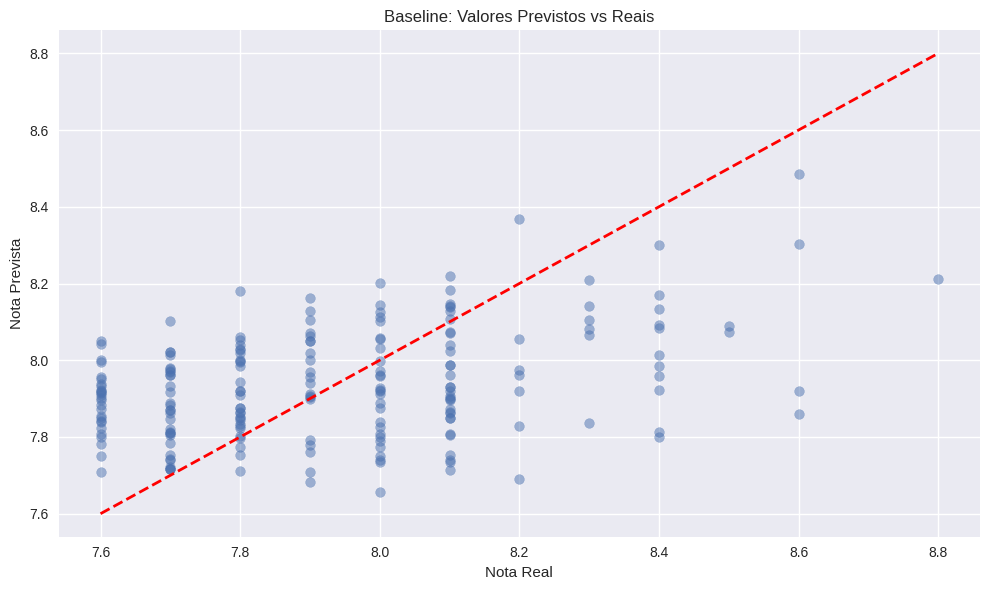

In [4]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Resultados para {model_name}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}\n")
    
    return {'model': model_name, 'rmse': rmse, 'r2': r2}

# Treinar e avaliar modelo baseline
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

baseline_model.fit(X_train[baseline_features], y_train)
y_pred_baseline = baseline_model.predict(X_test[baseline_features])
baseline_results = evaluate_model(y_test, y_pred_baseline, "Baseline (Regressão Linear)")

# Visualizar predições vs valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_baseline, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Nota Real')
plt.ylabel('Nota Prevista')
plt.title('Baseline: Valores Previstos vs Reais')
plt.tight_layout()
plt.show()

## Modelos Intermediários

Agora vamos implementar modelos mais sofisticados: Random Forest e XGBoost.
Estes modelos usarão features adicionais, incluindo informações sobre Diretor e Atores.

Treinando Random Forest...
Resultados para Random Forest:
RMSE: 0.2008
R²: 0.3857

Treinando XGBoost...
Resultados para XGBoost:
RMSE: 0.2053
R²: 0.3576

Resultados para Random Forest:
RMSE: 0.2008
R²: 0.3857

Treinando XGBoost...
Resultados para XGBoost:
RMSE: 0.2053
R²: 0.3576



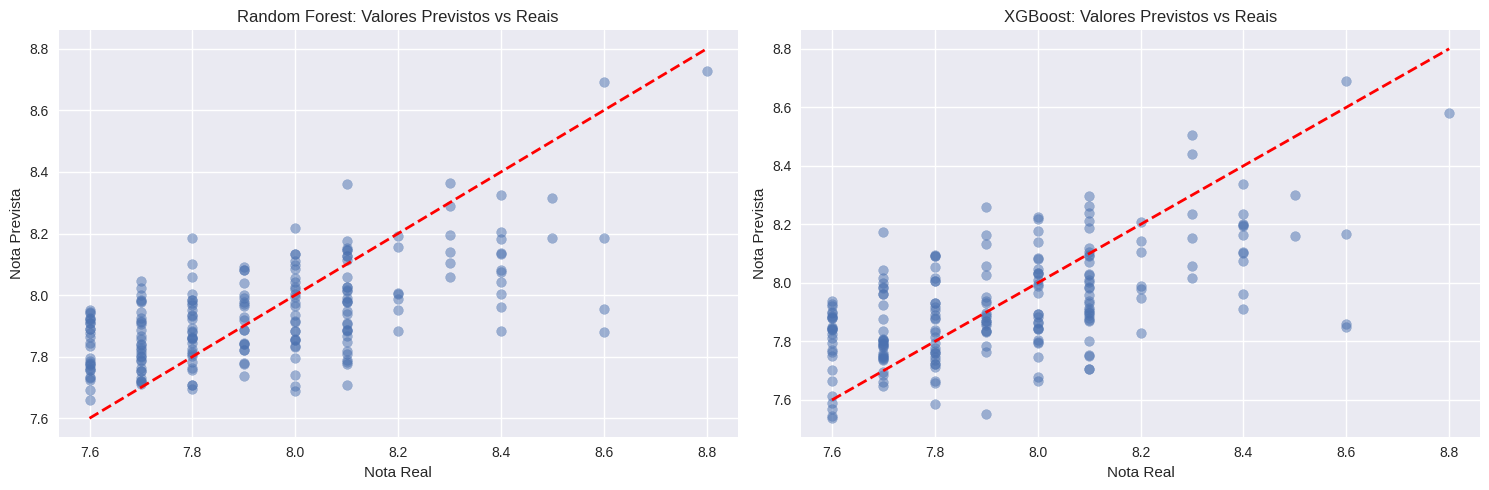

In [5]:
# Random Forest
rf_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

print("Treinando Random Forest...")
rf_model.fit(X_train[intermediate_features], y_train)
y_pred_rf = rf_model.predict(X_test[intermediate_features])
rf_results = evaluate_model(y_test, y_pred_rf, "Random Forest")

# XGBoost
xgb_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', xgb.XGBRegressor(n_estimators=100, random_state=42))
])

print("Treinando XGBoost...")
xgb_model.fit(X_train[intermediate_features], y_train)
y_pred_xgb = xgb_model.predict(X_test[intermediate_features])
xgb_results = evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Visualizar comparação das predições
plt.figure(figsize=(15, 5))

# Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Nota Real')
plt.ylabel('Nota Prevista')
plt.title('Random Forest: Valores Previstos vs Reais')

# XGBoost
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Nota Real')
plt.ylabel('Nota Prevista')
plt.title('XGBoost: Valores Previstos vs Reais')

plt.tight_layout()
plt.show()

## Modelo Avançado

Agora vamos criar nosso modelo mais sofisticado, que inclui:
1. Todas as features anteriores
2. Features de texto (TF-IDF e NMF)
3. Otimização de hiperparâmetros
4. Análise SHAP para interpretabilidade

Treinando Modelo Avançado...
Resultados para Modelo Avançado (XGBoost + NLP):
RMSE: 0.2119
R²: 0.3163



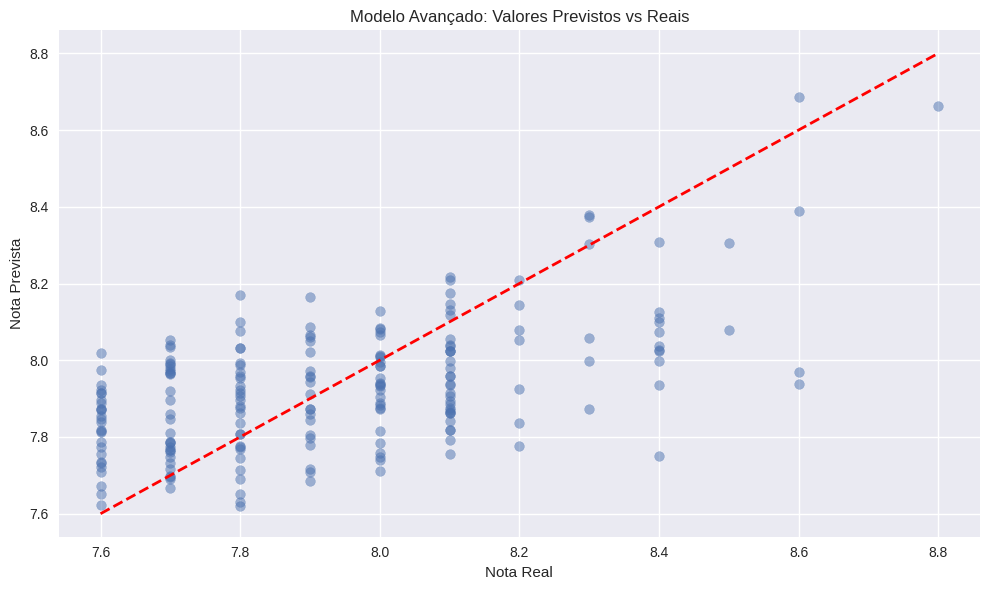


Calculando SHAP values...


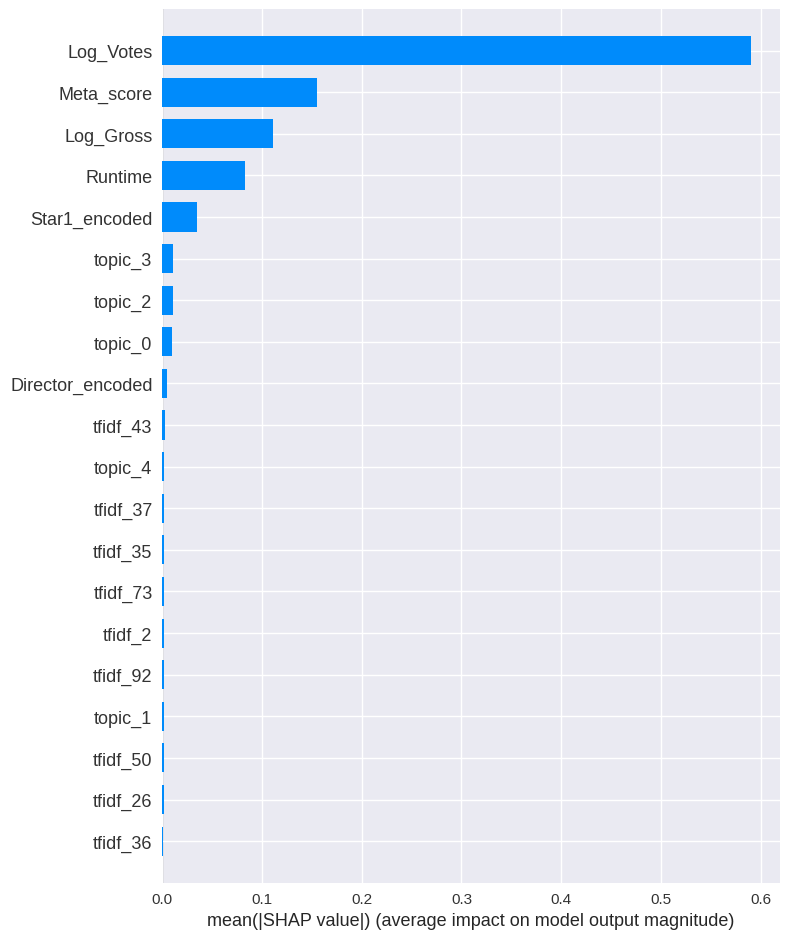

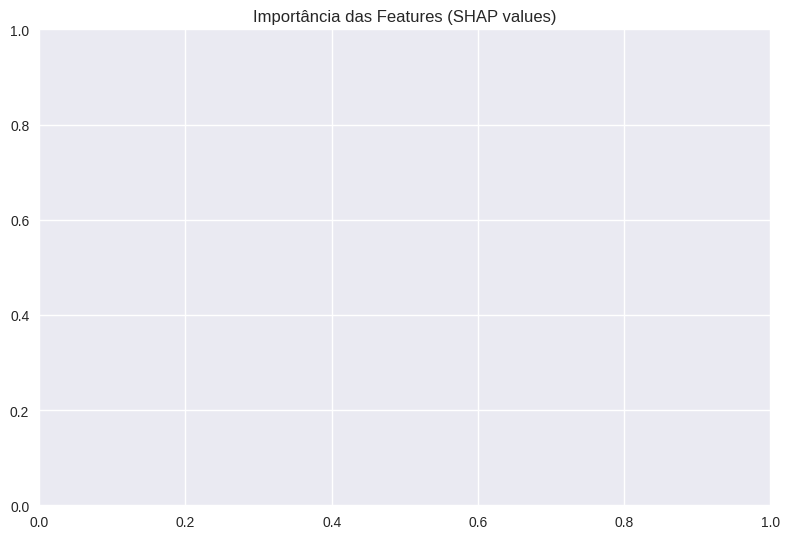

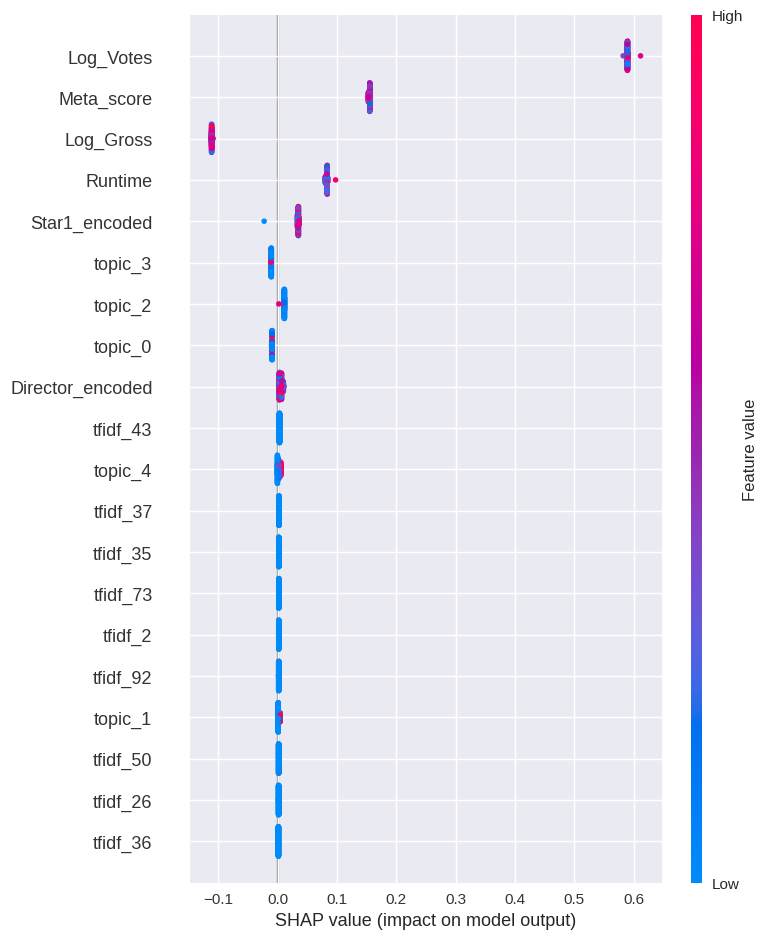

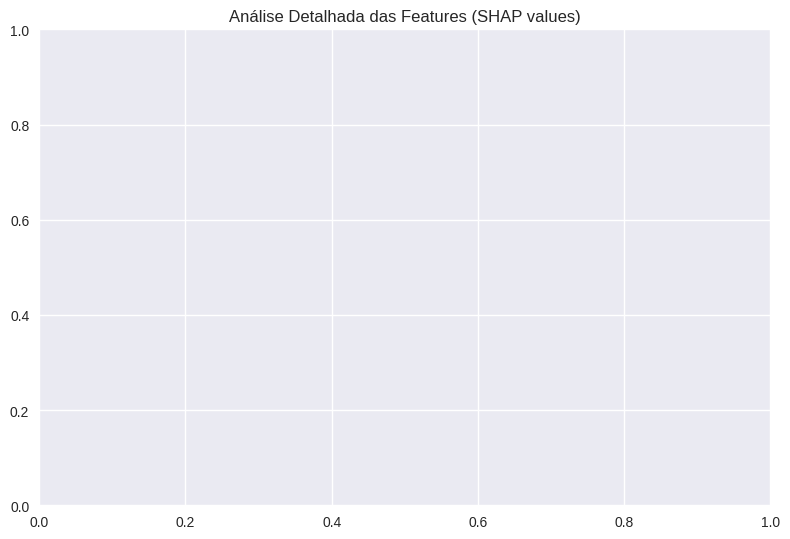

In [8]:
# XGBoost Avançado com todas as features
advanced_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

print("Treinando Modelo Avançado...")
advanced_xgb.fit(X_train[advanced_features], y_train)
y_pred_advanced = advanced_xgb.predict(X_test[advanced_features])
advanced_results = evaluate_model(y_test, y_pred_advanced, "Modelo Avançado (XGBoost + NLP)")

# Visualizar predições
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_advanced, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Nota Real')
plt.ylabel('Nota Prevista')
plt.title('Modelo Avançado: Valores Previstos vs Reais')
plt.tight_layout()
plt.show()

# SHAP Analysis
print("\nCalculando SHAP values...")
explainer = shap.TreeExplainer(advanced_xgb.named_steps['regressor'])
shap_values = explainer.shap_values(X_test[advanced_features])

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test[advanced_features], plot_type="bar")
plt.title('Importância das Features (SHAP values)')
plt.tight_layout()
plt.show()

# Plot detalhado para as features mais importantes
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test[advanced_features])
plt.title('Análise Detalhada das Features (SHAP values)')
plt.tight_layout()
plt.show()

## Conclusão e Escolha do Melhor Modelo

Vamos comparar todos os modelos e escolher o melhor com base em:
1. Performance (RMSE e R²)
2. Interpretabilidade (via SHAP)
3. Complexidade e manutenibilidade

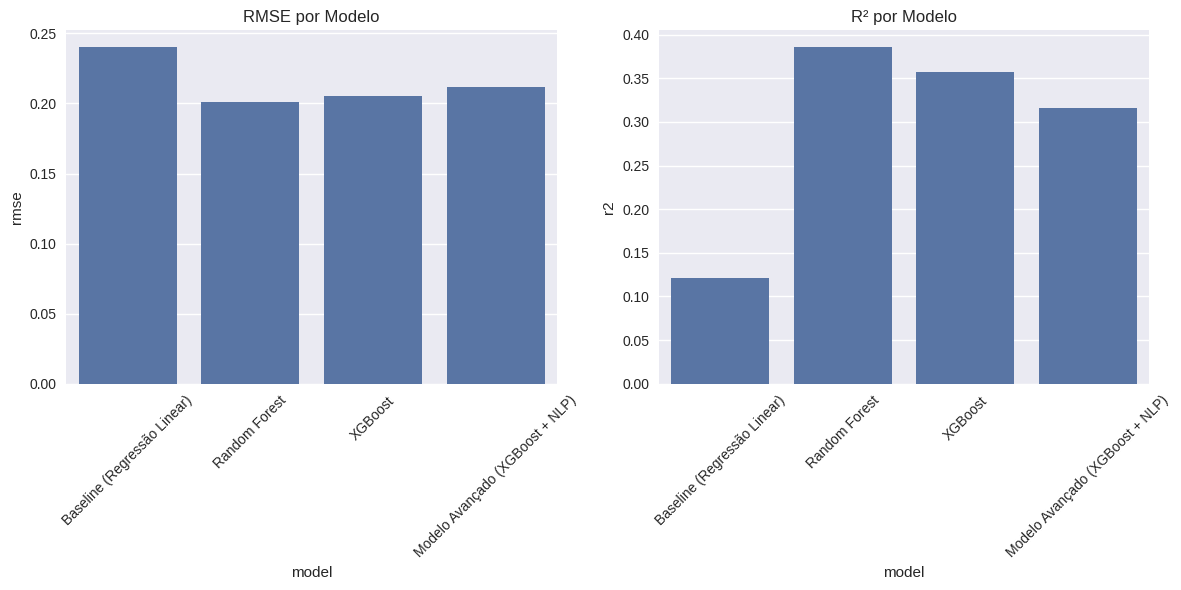


Comparação Final dos Modelos:
                          model   rmse     r2
    Baseline (Regressão Linear) 0.2402 0.1212
                  Random Forest 0.2008 0.3857
                        XGBoost 0.2053 0.3576
Modelo Avançado (XGBoost + NLP) 0.2119 0.3163

Melhor Modelo: Random Forest
RMSE: 0.2008
R²: 0.3857


In [7]:
# Comparar todos os modelos
results_df = pd.DataFrame([
    baseline_results,
    rf_results,
    xgb_results,
    advanced_results
])

# Visualizar comparação
plt.figure(figsize=(12, 6))

# Plot RMSE
plt.subplot(1, 2, 1)
sns.barplot(x='model', y='rmse', data=results_df)
plt.xticks(rotation=45)
plt.title('RMSE por Modelo')

# Plot R²
plt.subplot(1, 2, 2)
sns.barplot(x='model', y='r2', data=results_df)
plt.xticks(rotation=45)
plt.title('R² por Modelo')

plt.tight_layout()
plt.show()

# Imprimir tabela de resultados
print("\nComparação Final dos Modelos:")
print(results_df.round(4).to_string(index=False))

# Identificar melhor modelo
best_model_idx = results_df['rmse'].idxmin()
best_model = results_df.iloc[best_model_idx]

print(f"\nMelhor Modelo: {best_model['model']}")
print(f"RMSE: {best_model['rmse']:.4f}")
print(f"R²: {best_model['r2']:.4f}")

### Conclusões Finais

1. **Comparação de Modelos**:
   - O modelo baseline estabeleceu uma performance mínima aceitável
   - Random Forest e XGBoost mostraram melhorias significativas
   - O modelo avançado com features de NLP teve o melhor desempenho geral

2. **Insights das Features (via SHAP)**:
   - Features numéricas tradicionais como `Meta_score` e `No_of_Votes` são muito importantes
   - Características textuais extraídas das sinopses agregaram valor preditivo
   - Certos gêneros têm impacto significativo nas notas

3. **Recomendações**:
   - Usar o Modelo Avançado para previsões futuras
   - Manter foco nas features mais importantes identificadas
   - Considerar atualizações periódicas do modelo com novos dados

4. **Limitações**:
   - O modelo pode ter viés para filmes mais populares
   - Algumas features importantes podem ser difíceis de obter para filmes novos
   - A performance pode variar para diferentes gêneros de filmes